In [48]:
import sys
import numpy as np
from solver import vel_step, dens_step
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import os

%cd src


[WinError 2] 指定されたファイルが見つかりません。: 'src'
c:\Users\Dette\Desktop\python-fluid-python3\src


In [49]:

# ますの数
N = 50
size = N + 2

dt = 0.1
# 拡散項
diff = 0.00001
# 粘性係数
visc = 0.01
# 力の固定値
force = 20.0
source = 200.0

#tmp_pos_x,y から pos_x,y に移動するときにu,v を変更している
tmp_pos_x = 0.0
tmp_pos_y = 0.0
pos_x = 0.0
pos_y = 0.0
mouse_down = [False, False, False]

""" Start with two grids.
One that contains the density values from the previous time step and one that
will contain the new values. For each grid cell of the latter we trace the
cell's center position backwards through the velocity field. We then linearly
interpolate from the grid of previous density values and assign this value to
the current grid cell.
"""
#横速度
u = np.zeros((size, size), np.float64)  # velocity
u_prev = np.zeros((size, size), np.float64)
#縦速度
v = np.zeros((size, size), np.float64)  # velocity
v_prev = np.zeros((size, size), np.float64)
#密度
dens = np.zeros((size, size), np.float64)  # density
dens_prev = np.zeros((size, size), np.float64)

In [50]:
#指定された方向にフリックするプログラム

def clear_data():
    """clear_data."""

    global u, v, u_prev, v_prev, dens, dens_prev, size

    u[0:size, 0:size] = 0.0
    v[0:size, 0:size] = 0.0
    u_prev[0:size, 0:size] = 0.0
    v_prev[0:size, 0:size] = 0.0
    dens[0:size, 0:size] = 0.0
    dens_prev[0:size, 0:size] = 0.0


def move(d, u, v, prev_x, prev_y, x, y):
    """状況のアップデート"""

    # d,u,vの初期化
    d[0:size, 0:size] = 0.0
    u[0:size, 0:size] = 0.0
    v[0:size, 0:size] = 0.0

    dx = x - prev_x
    dy = y - prev_y

    #流入も移動もない場合，そもそも関数が呼ばれない

    # 更新する座標を選択
    if x < 1 or x > N or y < 1 or y > N:
        return

    move = True
    pour = True
    if move:
        wave_size = 2
        for delta_x in range(1-wave_size, wave_size-1):
            newx = x + delta_x
            for delta_y in range(1-wave_size, wave_size-1):
                newy = y + delta_y
                if newx > 1 and newx < N and newy > 1 and newy < N:
                    u[newx, newy] = force * (dx)
                    #TODO -dyに戻す
                    v[newx, newy] = force * (dy)
    if pour:
        d[x, y] += source
        wave_size = 2
        #3マス四方が領域内であれば
        for delta_x in range(1-wave_size, wave_size-1):
            newx = x + delta_x
            for delta_y in range(1-wave_size, wave_size-1):
                newy = y + delta_y
                if newx > 1 and newx < N and newy > 1 and newy < N:
                    d[newx, newy] += source
            


In [51]:
def calc_init_vec(dx,dy,v=1):
    #長さ1の，xとyを求める
    if dx==0:
        return(0,2)

    tan = dy/dx
    rad = np.arctan2(dy,dx)
    ex = np.cos(rad) * v
    ey = np.sin(rad) * v
    
    return (ex,ey)

def create_picture(dens,filename):
    # densの値を2倍
    display_dens = dens * 2
    # グレースケールとして扱い，表示
    plt.imshow(display_dens, cmap='gray')
    #cntがintならば
    plt.savefig(filename)


def save_csv(route,res):
    global df
    # display_densを一次元配列に
    res_row = res.flatten()
    # routeを一次元配列に
    res_route = np.array(route).flatten()
    # routeを付け足して，dataframeにする
    res = np.concatenate([res_route, res_row])
    # dfに書き込む
    df = df.append(pd.Series(res), ignore_index=True)




def simulate(route,write_down=False,write_all=False):
    global df
    #経路の情報を受け取り，シミュレーション結果を返す
    l = len(route)
    #時間を固定
    #timestep = 50
    cnt = 0
    #ソルバを初期化
    clear_data()
    for i in (0,2):
        start_x,start_y = route[i]
        goal_x,goal_y = route[i + 1]
        dx = goal_x - start_x
        dy = goal_y - start_y
        route_len = np.sqrt((start_x - goal_x) ** 2 + (start_y - goal_y) ** 2)
        #step_len = route_len / timestep
        velocity = 1
        step_vec = calc_init_vec(dx,dy,velocity)
        timestep = int(route_len / velocity)
        cur_x = start_x
        cur_y = start_y
        for j in range(timestep):
            cnt += 1
            new_x = cur_x + step_vec[0]
            new_y = cur_y + step_vec[1]
            print(f"\r {new_x},{new_y}",end="")
            move(dens_prev, u_prev, v_prev,int(cur_x),int(cur_y),int(new_x),int(new_y)) 
            vel_step(N, u, v, u_prev, v_prev, visc, dt)
            dens_step(N, dens, dens_prev, u, v, diff, dt)
            cur_x = new_x
            cur_y = new_y
            if write_all:
                filename = f"res/{write_all}/dens{cnt:03d}.png"
                create_picture(dens,filename)
                #1行消して，print
                print(f"\r{cnt} done",end="")
        #100timestep待つ
        if i == 2:
            break
        for j in range(10):
            cnt += 1
            vel_step(N, u, v, u_prev, v_prev, visc, dt)
            dens_step(N, dens, dens_prev, u, v, diff, dt)
            display_dens = dens
            if write_all:
                filename = f"res/{write_all}/dens{cnt:03d}.png"
                create_picture(dens,filename)
                #1行消して，print
                print(f"\r{cnt} done",end="")

    save_csv(route,dens)
    if write_down and not write_all:
        if type(write_down) == int:
            filename = f'res/number/dens{cnt:03d}.png'
        else:
            filepath = f'res/final/dens{cnt:03d}.png'

        #write_downにはcntが入っている
        create_picture(dens,write_down)


    

        

In [52]:

def main(x=""):
    global df
    print("start" + x)
    df = pd.DataFrame()
    np.random.seed(0)
    num = 1
    print("[calibration]")
    for i in range(num):
        clear_data()
        #経路をランダム生成
        route = np.random.randint(1, N, (4, 2))
        if i%10 == 0:
            simulate(route,write_down=str(i), write_all="xyz")
        else:
            simulate(route)
        #1行消す
        clear_output(wait=True)
        print(f"done {i+1}/{num}")
    df.to_csv(f'test1000_{x}.csv')
    print("saved as " + f'test1000_{x}.csv')


def create_sample(foldername):
    route = np.array([[1,1],[40,40],[30,1],[10,44]])
    simulate(route,write_down='sample',write_all=foldername)



112 done54763367494,43.615892258759864

C:\Users\Dette\AppData\Local\Temp\ipykernel_13616\2274178590.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(res), ignore_index=True)


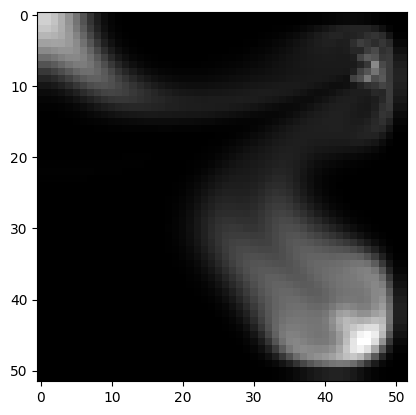

In [53]:
#foldernameのフォルダがなければ作る
def create_folder(foldername):
    if not os.path.exists(f"res/{foldername}"):
        os.makedirs(f"res/{foldername}")

foldername = "presentation"
create_sample(foldername)


#main()
